# SFC Example (Publication Style)

这个 notebook 提供更适合论文/汇报的图形风格：
- 统一配色与版式
- scenario 分组 + layout 组内对比
- 可选 `speedup` 视图（相对同 scenario 的 `no_layout` 中位数）


In [ ]:
# --- Bootstrap paths and imports ---
import sys
from pathlib import Path
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

NB_DIR = Path.cwd()
PROJ_ROOT = NB_DIR.parent
for p in (NB_DIR, PROJ_ROOT):
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))

try:
    %load_ext autoreload
    %autoreload 2
except Exception:
    pass

from viz_results_toolkit import savefig_multi
from scripts.parse_tpch_results import (
    collect_tpch_rq1_results,
    query_results_dataframe,
    load_scenario_configs,
)

out_dir = PROJ_ROOT / "viz_out_results"
out_dir.mkdir(parents=True, exist_ok=True)

# Clean publication-style defaults
mpl.rcParams.update({
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.spines.top": False,
    "axes.spines.right": True,
    "axes.linewidth": 0.8,
    "grid.color": "#D9D9D9",
    "grid.linewidth": 0.6,
    "grid.alpha": 0.75,
})


In [ ]:
# --- Constants and helpers ---
LAYOUT_ORDER = ["no_layout", "linear", "zorder", "hilbert"]
LAYOUT_COLORS = {
    "no_layout": "#4C78A8",
    "linear": "#F58518",
    "zorder": "#54A24B",
    "hilbert": "#E45756",
}

SCENARIO_ORDER = [
    "SCENARIO_DEFAULT",
    "SCENARIO_DEFAULT_V1",
    "SCENARIO_O2_V1",
    "SCENARIO_O2_V2",
    "SCENARIO_O3_V1",
    "SCENARIO_O3_V2",
    "SCENARIO_O4_V1",
    "SCENARIO_O4_V2",
]

SCENARIO_DISPLAY = {
    "SCENARIO_DEFAULT": "O1_V1",
    "SCENARIO_DEFAULT_V1": "O1_V2",
    "SCENARIO_O2_V1": "O2_V1",
    "SCENARIO_O2_V2": "O2_V2",
    "SCENARIO_O3_V1": "O3_V1",
    "SCENARIO_O3_V2": "O3_V2",
    "SCENARIO_O4_V1": "O4_V1",
    "SCENARIO_O4_V2": "O4_V2",
}

BLOCK_GAP = 0.9


def _normalize_layouts(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d["layout"] = d["layout"].fillna("baseline").replace({"baseline": "no_layout"})
    return d


def _load_sort_expr_map() -> dict[str, str]:
    configs = load_scenario_configs(PROJ_ROOT / "scripts" / "run_RQ_1_matrix.sh")
    mapping = {}
    for key, cfg in configs.items():
        sort_expr = cfg.options.get("sort", "")
        if sort_expr:
            mapping[key] = sort_expr
            mapping[cfg.display_name] = sort_expr
    return mapping


SORT_EXPR_MAP = _load_sort_expr_map()


def _normalize_sort_columns(sort_expr: str) -> list[str]:
    parts = [p.strip() for p in sort_expr.split(",") if p.strip()]
    cleaned = []
    for col in parts:
        cleaned.append(col[2:] if col.startswith("l_") else col)
    return cleaned


def _wrap_sort_label(sort_expr: str) -> str:
    cols = _normalize_sort_columns(sort_expr)
    if not cols:
        return ""
    if len(cols) == 1:
        return f"{cols[0]}\n"
    if len(cols) == 2:
        return f"{cols[0]},\n{cols[1]}"
    mid = (len(cols) + 1) // 2
    top = ", ".join(cols[:mid])
    bottom = ", ".join(cols[mid:])
    return f"{top},\n{bottom}" if bottom else f"{top}\n"


def _scenario_label(scenario_name: str, with_sort: bool = False) -> str:
    sort_expr = SORT_EXPR_MAP.get(scenario_name, "")
    cols = _normalize_sort_columns(sort_expr)
    if not cols:
        return ""
    if with_sort:
        return _wrap_sort_label(sort_expr)
    return ", ".join(cols)


def _metric_ylabel(metric: str, mode: str) -> str:
    if mode == "speedup":
        return "Speedup vs no_layout (median)"
    labels = {
        "elapsedTime_s": "Latency (s)",
        "executorRunTime_s": "Executor Runtime (s)",
        "bytes_scanned_ev": "Bytes Scanned (MB)",
        "files_scanned_ev": "Files Scanned (MB)",
    }
    return labels.get(metric, metric)


def _append_speedup_column(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    d = df.copy()
    med = d.groupby(["scenario_name", "layout"])[metric].median().reset_index()
    baseline = med[med["layout"] == "no_layout"][["scenario_name", metric]].rename(
        columns={metric: "baseline_median"}
    )
    med = med.merge(baseline, on="scenario_name", how="left")
    med["speedup"] = med["baseline_median"] / med[metric]
    d = d.merge(med[["scenario_name", "layout", "speedup"]], on=["scenario_name", "layout"], how="left")
    return d


In [10]:
# --- Main plotting function ---
def _plot_grouped_boxes_styled(
    df: pd.DataFrame,
    metric_col: str,
    *,
    scenario_order: list[str],
    layout_order: list[str],
    ax: plt.Axes,
    annotate_median: bool = True,
    with_sort_label: bool = False,
):
    cluster_centers = []
    cluster_labels = []
    block_spans = []
    seen_layouts = set()
    legend_handles = []
    pos = 1

    for scenario in scenario_order:
        df_s = df[df["scenario_name"] == scenario]
        if df_s.empty:
            continue

        start = pos
        has_data = False
        for layout in layout_order:
            vals = pd.to_numeric(df_s[df_s["layout"] == layout][metric_col], errors="coerce").dropna().values
            if vals.size == 0:
                continue

            has_data = True
            color = LAYOUT_COLORS.get(layout, "#999999")
            bp = ax.boxplot(
                vals,
                positions=[pos],
                widths=0.66,
                patch_artist=True,
                showfliers=False,
                medianprops={"color": "#222222", "linewidth": 1.6},
            )
            for patch in bp["boxes"]:
                patch.set_facecolor(color)
                patch.set_alpha(0.72)
                patch.set_edgecolor("#2B2B2B")
                patch.set_linewidth(0.8)
            for element in ("caps", "whiskers"):
                for artist in bp[element]:
                    artist.set_color("#555555")
                    artist.set_linewidth(0.8)

            med = float(np.median(vals))
            mean = float(np.mean(vals))
            ax.plot(pos, mean, marker="o", markersize=3.8, color="#111111", zorder=4)

            if annotate_median:
                ax.text(pos, med, f"{med:.2g}", ha="center", va="bottom", fontsize=7.5, color="#222222")

            if layout not in seen_layouts:
                legend_handles.append(mpatches.Patch(facecolor=color, edgecolor="#2B2B2B", label=layout))
                seen_layouts.add(layout)
            pos += 1

        if has_data:
            end = pos - 1
            cluster_centers.append((start + end) / 2)
            cluster_labels.append(_scenario_label(scenario, with_sort=with_sort_label))
            block_spans.append((start, end))
            ax.axvspan(start - 0.45, end + 0.45, color="#F5F7FA", alpha=0.35, zorder=0)
            pos += BLOCK_GAP

    if cluster_centers:
        ax.set_xticks(cluster_centers)
        ax.set_xticklabels(cluster_labels, rotation=0, ha="center")

    for _, e in block_spans[:-1]:
        ax.axvline(e + BLOCK_GAP / 2, linestyle="--", color="#B6B6B6", linewidth=0.8, alpha=0.8)

    ax.grid(True, axis="y")
    return legend_handles


def plot_rq1_tpch_queries_premium(
    queries,
    *,
    selectivity_filter=("S1",),
    column_config="C1_N2_O1",
    metric="bytes_scanned_ev",
    mode="raw",  # raw | speedup
    scenario_order=None,
    layout_order=None,
    ncols=2,
    log_scale=False,
    with_sort_label=False,
    annotate_median=True,
    save=True,
    filename=None,
    save_formats=("png", "pdf"),
):
    if not queries:
        raise ValueError("Provide at least one query id")

    collection = collect_tpch_rq1_results()
    scenario_order = scenario_order or SCENARIO_ORDER
    layout_order = layout_order or LAYOUT_ORDER

    panels = []
    for query_id in queries:
        df_q = query_results_dataframe(collection, query_id).copy()
        df_q = _normalize_layouts(df_q)
        if selectivity_filter:
            df_q = df_q[df_q["selectivity_label"].isin(selectivity_filter)]
        if column_config:
            df_q = df_q[df_q["column_config"] == column_config]
        df_q = df_q[df_q["layout"].isin(layout_order)]
        if df_q.empty:
            print(f"[warn] no rows for {query_id} after filtering")
            continue

        if mode == "speedup":
            df_q = _append_speedup_column(df_q, metric)
            metric_col = "speedup"
        else:
            metric_col = metric

        df_q[metric_col] = pd.to_numeric(df_q[metric_col], errors="coerce")
        df_q = df_q.dropna(subset=[metric_col])
        if df_q.empty:
            print(f"[warn] all values are NaN for {query_id} / {metric_col}")
            continue

        panels.append((query_id, df_q, metric_col))

    if not panels:
        raise ValueError("No query produced data; adjust filters")

    n = len(panels)
    ncols = max(1, min(ncols, n))
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6.8 * ncols, 4.2 * nrows), squeeze=False)

    legend_handles = []
    seen = set()

    for i, (query_id, df_panel, metric_col) in enumerate(panels):
        r, c = divmod(i, ncols)
        ax = axes[r][c]

        present_scenarios = sorted(df_panel["scenario_name"].dropna().unique())
        scenario_priority = [s for s in scenario_order if s in present_scenarios]
        scenario_priority += [s for s in present_scenarios if s not in scenario_priority]

        handles = _plot_grouped_boxes_styled(
            df_panel,
            metric_col,
            scenario_order=scenario_priority,
            layout_order=layout_order,
            ax=ax,
            annotate_median=annotate_median,
            with_sort_label=with_sort_label,
        )

        # ax.set_title(f"{query_id}  (n={len(df_panel)})", pad=10)
        ax.set_ylabel(_metric_ylabel(metric, mode))
        if mode == "speedup":
            ax.axhline(1.0, color="#2B2B2B", linestyle="--", linewidth=0.9)
        if log_scale and mode == "raw":
            ax.set_yscale("log")

        for h in handles:
            label = h.get_label()
            if label not in seen:
                legend_handles.append(h)
                seen.add(label)

    for k in range(n, nrows * ncols):
        r, c = divmod(k, ncols)
        axes[r][c].axis("off")

    fig.suptitle(
        f"RQ1 TPCH - {'Speedup' if mode == 'speedup' else metric} by Scenario and Layout",
        y=0.995,
        fontsize=13,
    )

    if legend_handles:
        fig.legend(
            legend_handles,
            [h.get_label() for h in legend_handles],
            loc="upper center",
            bbox_to_anchor=(0.5, 0.965),
            ncol=len(legend_handles),
            frameon=False,
            handlelength=2.2,
            columnspacing=1.2,
        )

    fig.tight_layout(rect=(0, 0, 1, 0.94))

    if save:
        default_name = f"sfc_example_{mode}_{metric}"
        stem = filename or default_name
        try:
            savefig_multi(fig, out_dir / stem, fmts=save_formats, dpi=300)
        except PermissionError:
            fmt_list = [save_formats] if isinstance(save_formats, str) else list(save_formats)
            for fmt in fmt_list:
                ext = str(fmt).lstrip(".")
                fig.savefig((out_dir / stem).with_suffix(f".{ext}"), dpi=300, bbox_inches="tight")

    return fig



def plot_rq1_tpch_single_query_dual_axis(
    query_id,
    *,
    selectivity_filter=("S1",),
    column_config="C1_N2_O1",
    metric="bytes_scanned_ev",
    scenario_filter=None,
    scenario_order=None,
    layout_order=None,
    with_sort_label=False,
    annotate_metric_median=True,
    annotate_speedup=True,
    save=True,
    filename=None,
    save_formats=("png", "pdf"),
):
    """
    Single-query dual-axis view:
    - Left axis: raw metric boxplots by (scenario, layout)
    - Right axis: median speedup points vs no_layout within each scenario
    - Speedup labels are shown above diamonds (e.g., 1.8x)
    """
    collection = collect_tpch_rq1_results()
    layout_order = layout_order or LAYOUT_ORDER
    scenario_order = scenario_order or SCENARIO_ORDER

    df = query_results_dataframe(collection, query_id).copy()
    df = _normalize_layouts(df)
    if selectivity_filter:
        df = df[df["selectivity_label"].isin(selectivity_filter)]
    if column_config:
        df = df[df["column_config"] == column_config]
    if scenario_filter:
        df = df[df["scenario_name"].isin(scenario_filter)]
    df = df[df["layout"].isin(layout_order)]

    df[metric] = pd.to_numeric(df[metric], errors="coerce")
    df = df.dropna(subset=[metric])
    if df.empty:
        raise ValueError("No rows after filtering")

    present_scenarios = sorted(df["scenario_name"].dropna().unique())
    scenario_priority = [s for s in scenario_order if s in present_scenarios]
    scenario_priority += [s for s in present_scenarios if s not in scenario_priority]

    med = (
        df.groupby(["scenario_name", "layout"])[metric]
        .median()
        .reset_index(name="metric_median")
    )
    baseline = (
        med[med["layout"] == "no_layout"][["scenario_name", "metric_median"]]
        .rename(columns={"metric_median": "baseline_median"})
    )
    med = med.merge(baseline, on="scenario_name", how="left")
    med["speedup"] = med["baseline_median"] / med["metric_median"]

    fig, ax1 = plt.subplots(figsize=(7.8, 3.8))
    ax2 = ax1.twinx()

    cluster_centers = []
    cluster_labels = []
    block_spans = []
    legend_handles = []
    seen_layouts = set()
    pos = 1

    for scenario in scenario_priority:
        df_s = df[df["scenario_name"] == scenario]
        if df_s.empty:
            continue

        start = pos
        has_data = False
        for layout in layout_order:
            vals = pd.to_numeric(df_s[df_s["layout"] == layout][metric], errors="coerce").dropna().values
            if vals.size == 0:
                continue
            has_data = True

            color = LAYOUT_COLORS.get(layout, "#999999")
            bp = ax1.boxplot(
                vals,
                positions=[pos],
                widths=0.66,
                patch_artist=True,
                showfliers=False,
                medianprops={"color": "#222222", "linewidth": 1.6},
            )
            for patch in bp["boxes"]:
                patch.set_facecolor(color)
                patch.set_alpha(0.72)
                patch.set_edgecolor("#2B2B2B")
                patch.set_linewidth(0.8)
            for element in ("caps", "whiskers"):
                for artist in bp[element]:
                    artist.set_color("#555555")
                    artist.set_linewidth(0.8)

            mean_val = float(np.mean(vals))
            med_val = float(np.median(vals))
            ax1.plot(pos, mean_val, marker="o", markersize=3.8, color="#111111", zorder=4)
            if annotate_metric_median:
                ax1.text(pos, med_val, f"{med_val:.2g}", ha="center", va="bottom", fontsize=7.3, color="#222222")

            sp_row = med[(med["scenario_name"] == scenario) & (med["layout"] == layout)]
            if not sp_row.empty and pd.notna(sp_row.iloc[0]["speedup"]):
                sp = float(sp_row.iloc[0]["speedup"])
                ax2.scatter(
                    [pos],
                    [sp],
                    marker="D",
                    s=44,
                    facecolor="white",
                    edgecolor=color,
                    linewidth=1.2,
                    zorder=6,
                )
                if annotate_speedup:
                    ax2.annotate(
                        f"{sp:.2g}x",
                        xy=(pos, sp),
                        xytext=(0, 6),
                        textcoords="offset points",
                        ha="center",
                        va="bottom",
                        fontsize=8.5,
                        color=color,
                        rotation=30,
                        zorder=7,
                    )

            if layout not in seen_layouts:
                legend_handles.append(mpatches.Patch(facecolor=color, edgecolor="#2B2B2B", label=layout))
                seen_layouts.add(layout)

            pos += 1

        if has_data:
            end = pos - 1
            cluster_centers.append((start + end) / 2)
            cluster_labels.append(_scenario_label(scenario, with_sort=with_sort_label))
            block_spans.append((start, end))
            ax1.axvspan(start - 0.45, end + 0.45, color="#F5F7FA", alpha=0.35, zorder=0)
            pos += BLOCK_GAP

    if cluster_centers:
        ax1.set_xticks(cluster_centers)
        ax1.set_xticklabels(cluster_labels, rotation=0, ha="center")

    for _, e in block_spans[:-1]:
        ax1.axvline(e + BLOCK_GAP / 2, linestyle="--", color="#B6B6B6", linewidth=0.8, alpha=0.8)

    # ax1.set_title(f"{query_id}  (n={len(df)})", pad=10)
    ax1.set_ylabel(_metric_ylabel(metric, "raw"))
    ax1.grid(True, axis="y")

    ax2.set_ylabel("Speedup vs no layout (median)")
    ax2.spines["right"].set_visible(True)
    ax2.spines["right"].set_linewidth(0.8)
    ax2.axhline(1.0, color="#2B2B2B", linestyle="--", linewidth=0.9)

    speedup_handle = Line2D(
        [0], [0],
        marker="D",
        markersize=6,
        markerfacecolor="white",
        markeredgecolor="#333333",
        linewidth=0,
        label="speedup (right axis)",
    )

    if legend_handles:
        fig.legend(
            legend_handles + [speedup_handle],
            [h.get_label() for h in legend_handles] + [speedup_handle.get_label()],
            loc="upper center",
            bbox_to_anchor=(0.5, 0.985),
            ncol=len(legend_handles) + 1,
            frameon=False,
            handlelength=2.0,
            columnspacing=1.1,
            fontsize=13,
        )

    # fig.suptitle("RQ1 TPCH - Raw metric + speedup (dual axis)", y=0.998, fontsize=13)
    fig.tight_layout(rect=(0, 0, 1, 0.93))

    if save:
        default_name = f"sfc_example_dual_axis_{query_id}_{metric}"
        stem = filename or default_name
        try:
            savefig_multi(fig, out_dir / stem, fmts=save_formats, dpi=300)
        except PermissionError:
            fmt_list = [save_formats] if isinstance(save_formats, str) else list(save_formats)
            for fmt in fmt_list:
                ext = str(fmt).lstrip(".")
                fig.savefig((out_dir / stem).with_suffix(f".{ext}"), dpi=300, bbox_inches="tight")

    summary = (
        med[["scenario_name", "layout", "metric_median", "baseline_median", "speedup"]]
        .sort_values(["scenario_name", "layout"])
        .reset_index(drop=True)
    )
    return fig, summary


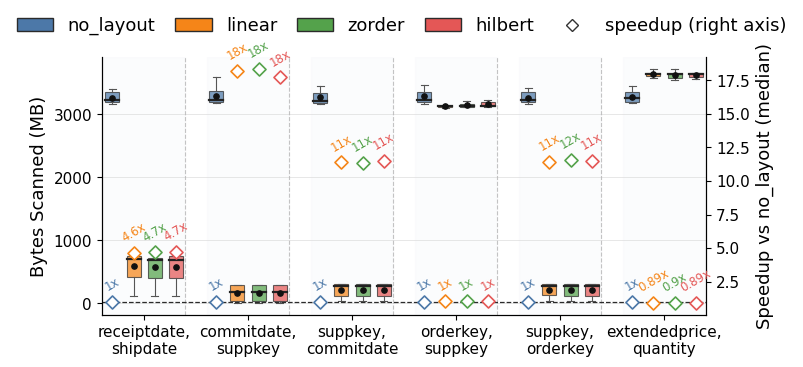

In [11]:
# --- Example output (dual-axis in one figure) ---
QUERY_ID = "Q2_N2_2"

fig, summary = plot_rq1_tpch_single_query_dual_axis(
    QUERY_ID,
    selectivity_filter=["S1"],
    column_config="C1_N2_O1",
    metric="bytes_scanned_ev",
    scenario_filter=[
        "SCENARIO_DEFAULT_V1",
        "SCENARIO_O2_V1",
        "SCENARIO_O2_V2",
        "SCENARIO_O3_V1",
        "SCENARIO_O3_V2",
        "SCENARIO_O4_V1",
    ],
    with_sort_label=True,
    annotate_metric_median=False,
    annotate_speedup=True,
    filename="sfc_example_dual_axis_Q2_N2_2_bytes_scanned_ev",
)

# summary
